# Algorithmic Trading Model for [Simple Moving Average Crossover] Using Python Version 1
### David Lowe
### October 28, 2020

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template. We will test trading models with the strategy of [Simple Moving Average Crossover].

INTRODUCTION: [SAMPLE PARAGRAPH - This algorithmic trading model examines a series of simple moving average (MA) crossover models via a grid search methodology. For the momentum-based models, the strategy goes long (buys) on the stock when the fast MA curve crosses above the slow MA curve. We will exit the long position when the fast MA curve crosses below the slow MA curve. For the mean-reversion models, we will populate the model using the exact opposite approach.]

ANALYSIS: [SAMPLE PARAGRAPH - From this iteration, we analyzed the stock prices for Apple Inc. (AAPL) between January 1, 2019, and September 30, 2020. The best model is momentum-based with a 20-day fast MA and a 10-day slow MA, and it produced a profit of 80.42 per share. The buy-and-hold approach yielded a gain of 77.09 per share.]

CONCLUSION: [SAMPLE PARAGRAPH - For the stock of AAPL during the modeling time frame, the trading strategy produced a better return than the buy-and-hold approach. We should consider modeling this stock further by using the same method.]

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Quandl

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Implement and Train Models
4. Back-test Models
5. Evaluate Strategy Performance

## Task 1 - Prepare Environment

In [1]:
# # Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# # Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
#
# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# # Retrieve the CPU information
# ncpu = !nproc
# print("The number of available CPUs is:", ncpu[0])

### 1.a) Load libraries and modules

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from datetime import date, datetime, timedelta
import requests
import json
from dotenv import load_dotenv
import pandas_datareader.data as pdr

### 1.b) Set up the controlling parameters and functions¶

In [6]:
stock_symbol = 'AAPL'
initial_capital = 0

# Specify the moving average parameters for the trading strategy
fast_sma_min = 10
fast_sma_max = 30
slow_sma_min = 10
slow_sma_max = 60
ma_increment = 5
min_ma_gap = 5

# The number of extra days of data we need (usually equals to the larger of slow_ema or slow_sma)
extra_days_data = slow_sma_max

model_start_date = date(2019, 1, 1)
print("Starting date for the model:", model_start_date)

# model_end_date = date()
model_end_date = date(2020, 9, 30)
print("Ending date for the model:", model_end_date)

data_start_date = model_start_date - timedelta(days=int(extra_days_data*1.5)) # Need more pricing data to calculate moving averages
print("First date of data we need for modeling:", data_start_date)

data_end_date = model_end_date
print("Last date of data we need for modeling:", data_end_date)

Starting date for the model: 2019-01-01
Ending date for the model: 2020-09-30
First date of data we need for modeling: 2018-10-03
Last date of data we need for modeling: 2020-09-30


In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Configure the plotting style
plt.style.use('seaborn')

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose_models = False
verbose_graphs = False
verbose_portfolios = False

In [8]:
# Set up the parent directory location for loading the dotenv files

# # Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# # Set up access to the dotenv file on local PC
# env_path = "/Users/david/PycharmProjects/"
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

## Task 2 - Acquire and Pre-Process Data

In [9]:
# Set up the data service provider and data acquisition parameters
data_service = 'Quandl'

# Check and see whether the API key is available
api_key = os.environ.get('QUANDL_API')
if api_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

start_date_string = data_start_date.strftime('%Y-%m-%d')
end_date_string = data_end_date.strftime('%Y-%m-%d')
api_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, stock_symbol, api_key)
response = requests.get(api_url)
resp_dict = json.loads(response.text)
stock_rawdata = pd.DataFrame(resp_dict['datatable']['data'])
print(len(stock_rawdata), 'data points retrieved from the API call.')
print()

stock_rawdata.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'closeunadj', 'lastupdated']
# stock_rawdata.set_index('date', inplace=True)
stock_rawdata.index = pd.to_datetime(stock_rawdata.date)
stock_pricing = stock_rawdata.sort_index(ascending=True)
print(stock_pricing.head())
print()
print(stock_pricing.tail())

502 data points retrieved from the API call.

           ticker        date    open    high     low   close       volume  dividend  closeunadj lastupdated
date                                                                                                        
2018-10-03   AAPL  2018-10-03  57.513  58.367  57.445  58.017  114619196.0       0.0      232.07  2020-08-31
2018-10-04   AAPL  2018-10-04  57.695  58.087  56.682  56.998  128168000.0       0.0      227.99  2020-08-31
2018-10-05   AAPL  2018-10-05  56.990  57.102  55.145  56.072  134321852.0       0.0      224.29  2020-08-31
2018-10-08   AAPL  2018-10-08  55.553  56.200  55.050  55.943  118655692.0       0.0      223.77  2020-08-31
2018-10-09   AAPL  2018-10-09  55.910  56.818  55.562  56.718  107564116.0       0.0      226.87  2020-08-31

           ticker        date    open    high     low   close       volume  dividend  closeunadj lastupdated
date                                                                             

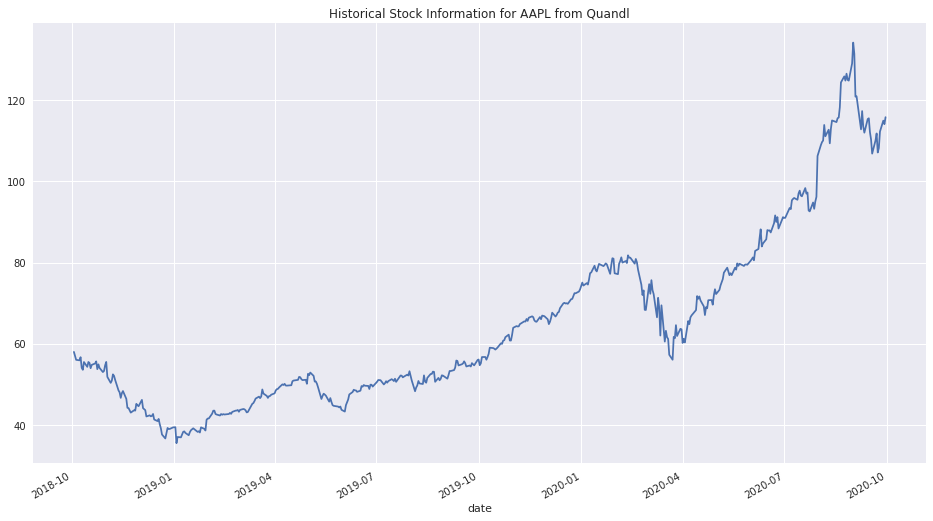

In [10]:
# Set up the standard column name for modeling
# Column names may be data-provider specific!
model_template = stock_pricing.loc[:, ['open','close']]
model_template.rename(columns={'open': 'open_price', 'close': 'close_price'}, inplace=True)
plot_title = 'Historical Stock Information for ' + stock_symbol + ' from ' + data_service
model_template['close_price'].plot(figsize=(16,9), title=plot_title)
plt.show()

## Task 3 - Implement and Train Models

In [11]:
# Define the functions that will generate the indicators and trading signals

def populate_indicators(passed_model):
    passed_model['fast_sma'] = passed_model['close_price'].rolling(fast_ma).mean()
    passed_model['slow_sma'] = passed_model['close_price'].rolling(slow_ma).mean()
    passed_model['sma_change'] = passed_model['fast_sma'] - passed_model['slow_sma']
    passed_model['trade_signal'] = np.zeros(len(passed_model))
    passed_model['signal_change'] = np.zeros(len(passed_model))
    passed_model['entry_exit'] = np.zeros(len(passed_model))

def populate_momentum_signals(model, change_curve):
    wait_for_entry = True # If True, we will wait for the next entry point when the signal changes from neutral to long
    for x in range(len(model)):
        if model[change_curve].iloc[x] > 0:
            model['trade_signal'].iloc[x] = 1  # trade_signal = 1 means we should be in a long position
        else:
            model['trade_signal'].iloc[x] = 0  # trade_signal = 0 means we should be in a neutral position
        if x != 0:
            model['signal_change'].iloc[x] = model['trade_signal'].iloc[x] - model['trade_signal'].iloc[x-1]
            # IF logics to handle the very first entry and the subsequent entries and exits
            if wait_for_entry and (model['signal_change'].iloc[x-1] == 1):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]
                wait_for_entry = False
            elif (not wait_for_entry) and (model['signal_change'].iloc[x-1] != 0):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]

def populate_reversion_signals(model, change_curve):
    wait_for_entry = True # If True, we will wait for the next entry point when the signal changes from neutral to long
    for x in range(len(model)):
        if model[change_curve].iloc[x] < 0:
            model['trade_signal'].iloc[x] = 1  # trade_signal = 1 means we should be in a long position
        else:
            model['trade_signal'].iloc[x] = 0  # trade_signal = 0 means we should be in a neutral position
        if x != 0:
            model['signal_change'].iloc[x] = model['trade_signal'].iloc[x] - model['trade_signal'].iloc[x-1]
            # IF logics to handle the very first entry and the subsequent entries and exits
            if wait_for_entry and (model['signal_change'].iloc[x-1] == 1):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]
                wait_for_entry = False
            elif (not wait_for_entry) and (model['signal_change'].iloc[x-1] != 0):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]

In [12]:
# Processing momentum models using the SMA curves
print()
momentum_fast_sma_slow_sma_models = {}
serial_number = 1
for slow_ma in range(slow_sma_min, slow_sma_max+1, ma_increment):
    for fast_ma in range(fast_sma_min, fast_sma_max+1, ma_increment):
        if (slow_ma - fast_ma) < min_ma_gap: break
        if verbose_models: print('Processing momentum model with fast_sma of', fast_ma, 'and slow_sma of', slow_ma)
        model_tag = 'Momentum_' + str(serial_number).zfill(3) + '_FastSMA_' + str(fast_ma).zfill(3) + '_SlowSMA_' + str(slow_ma).zfill(3)
        serial_number = serial_number + 1
        trading_model = model_template.copy()
        populate_indicators(trading_model)
        trading_model = trading_model[model_start_date:model_end_date]
        populate_momentum_signals(trading_model, 'sma_change')
        momentum_fast_sma_slow_sma_models[model_tag] = trading_model.copy()
        if verbose_models: print('Model', model_tag, 'added to the trading model collection.')
print(len(momentum_fast_sma_slow_sma_models), 'momentum SMA-only models generated!')

# Processing mean-reversion models using only the SMA curves
print()
reversion_fast_sma_slow_sma_models = {}
serial_number = 1
for slow_ma in range(slow_sma_min, slow_sma_max+1, ma_increment):
    for fast_ma in range(fast_sma_min, fast_sma_max+1, ma_increment):
        if (slow_ma - fast_ma) < min_ma_gap: break
        if verbose_models: print('Processing mean-reversion model with fast_sma of', fast_ma, 'and slow_sma of', slow_ma)
        model_tag = 'Reversion_' + str(serial_number).zfill(3) + '_FastSMA_' + str(fast_ma).zfill(3) + '_SlowSMA_' + str(slow_ma).zfill(3)
        serial_number = serial_number + 1
        trading_model = model_template.copy()
        populate_indicators(trading_model)
        trading_model = trading_model[model_start_date:model_end_date]
        populate_reversion_signals(trading_model, 'sma_change')
        reversion_fast_sma_slow_sma_models[model_tag] = trading_model.copy()
        if verbose_models: print('Model', model_tag, 'added to the trading model collection.')
print(len(reversion_fast_sma_slow_sma_models), 'mean-reversion SMA-only models generated!')


40 momentum SMA-only models generated!

40 mean-reversion SMA-only models generated!


In [13]:
# List the entry/exit points for each model
def list_model_entry_exit(model_collection):
    for model_name in model_collection:
        print('List the signal change and entry/exit points for', model_name)
        print(model_collection[model_name][(model_collection[model_name].signal_change != 0) | (model_collection[model_name].entry_exit != 0)])
        print()

In [14]:
if verbose_models: list_model_entry_exit(momentum_fast_sma_slow_sma_models)

In [15]:
if verbose_models: list_model_entry_exit(reversion_fast_sma_slow_sma_models)

In [16]:
def draw_model_graphs(model_name, trade_model, fast_ma_curve='fast_sma', slow_ma_curve='slow_sma'):
    graph_data = trade_model.copy()
    title_string = "Moving Average Crossover Model for " + model_name
    fig = plt.figure(figsize=(16,9))
    ylabel = stock_symbol + ' price in $'
    ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
    graph_data[fast_ma_curve].plot(ax=ax1, color='b', lw=2.)
    graph_data[slow_ma_curve].plot(ax=ax1, color='r', lw=2.)
    graph_data['close_price'].plot(ax=ax1, color='g')
    ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
    ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
    plt.legend(loc='upper left')
    plt.show()

In [17]:
if verbose_graphs:
    for tag in momentum_fast_sma_slow_sma_models:
        draw_model_graphs(tag, momentum_fast_sma_slow_sma_models[tag], 'fast_sma', 'slow_sma')

In [18]:
if verbose_graphs:
    for tag in reversion_fast_sma_slow_sma_models:
        draw_model_graphs(tag, reversion_fast_sma_slow_sma_models[tag], 'fast_sma', 'slow_sma')

## Task 4 - Back-test Models

In [19]:
def generate_trading_portfolios(initial_fund, trade_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trade_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction', 'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accumu_return'])
    portfolio.iloc[0]['trade_action'] = 0
    portfolio.iloc[0]['qty_onhand'] = 0
    portfolio.iloc[0]['cost_basis'] = 0.00
    portfolio.iloc[0]['sold_transaction'] = 0.00
    portfolio.iloc[0]['gain_loss'] = 0.00
    portfolio.iloc[0]['cash_onhand'] = initial_capital
    portfolio.iloc[0]['position_value'] = 0.00
    portfolio.iloc[0]['total_position'] = initial_capital
    portfolio.iloc[0]['accumu_return'] = portfolio.iloc[0]['total_position'] - initial_fund
    recent_cost = 0

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        if (trade_model.iloc[i]['entry_exit'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0):
            portfolio.iloc[i]['trade_action'] = 1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
            recent_cost = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            if verbose_portfolios: print('BOUGHT QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        elif (trade_model.iloc[i]['entry_exit'] == -1) and (portfolio.iloc[i-1]['qty_onhand'] > 0):
            portfolio.iloc[i]['trade_action'] = -1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = 0.00
            portfolio.iloc[i]['sold_transaction'] = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'] * -1
            portfolio.iloc[i]['gain_loss'] = (recent_cost + (trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'])) * -1
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
            recent_cost = 0.00
            if verbose_portfolios: print('SOLD QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        else:
            portfolio.iloc[i]['trade_action'] = 0
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
            portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
        portfolio.iloc[i]['position_value'] = trade_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
        portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
        portfolio.iloc[i]['accumu_return'] = portfolio.iloc[i]['total_position'] - initial_fund

    return portfolio

In [20]:
def calculate_portfolio_performance(model_collection):
    # Initialize a dictionary for tracking portfolios for all models
    portfolio_collection = {}
    # Initialize a dataframe for reporting model performance summary
    performance_summary = pd.DataFrame(columns=['model_name','return_value','return_percent'])

    for model_name in model_collection:
        if verbose_portfolios: print('Processing portfolio for model:', model_name)
        portfolio_collection[model_name] = generate_trading_portfolios(initial_capital, model_collection[model_name])
        trade_transactions = portfolio_collection[model_name][portfolio_collection[model_name].trade_action != 0]
        if verbose_portfolios: print(trade_transactions)
        if verbose_portfolios: print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (initial_capital, portfolio_collection[model_name].accumu_return[-1]))
        if initial_capital != 0:
            return_percentage = portfolio_collection[model_name].accumu_return[-1] / initial_capital * 100
            if verbose_portfolios: print('Accumulated return percentage based on the initial capital investment: %.2f%%' % return_percentage)
        else:
            return_percentage = None
        if trade_transactions.iloc[-1]['trade_action'] == 1:
            if verbose_portfolios: print('The current status of the model is:', 'Holding a position since', trade_transactions.index.tolist()[-1], '\n')
        else:
            if verbose_portfolios: print('The current status of the model is:', 'Waiting to enter since', trade_transactions.index.tolist()[-1], '\n')
        performance_summary = performance_summary.append({'model_name': model_name, 'return_value': portfolio_collection[model_name].accumu_return[-1], 'return_percent': return_percentage}, ignore_index=True)
    performance_summary.sort_values(by=['return_value'], inplace=True, ascending=False)
    return portfolio_collection, performance_summary

In [21]:
momentum_fast_sma_slow_sma_portfolios, momentum_fast_sma_slow_sma_performance = calculate_portfolio_performance(momentum_fast_sma_slow_sma_models)
print(len(momentum_fast_sma_slow_sma_portfolios), 'momentum trading transaction portfolios generated.')
print(len(momentum_fast_sma_slow_sma_performance), 'profit/loss performance summaries generated.')
print()
print(momentum_fast_sma_slow_sma_performance.head())

40 momentum trading transaction portfolios generated.
40 profit/loss performance summaries generated.

                              model_name  return_value return_percent
1   Momentum_002_FastSMA_010_SlowSMA_020        80.419           None
35  Momentum_036_FastSMA_010_SlowSMA_060        73.867           None
3   Momentum_004_FastSMA_010_SlowSMA_025        73.625           None
22  Momentum_023_FastSMA_020_SlowSMA_045        70.358           None
14  Momentum_015_FastSMA_030_SlowSMA_035        69.936           None


In [22]:
reversion_fast_sma_slow_sma_portfolios, reversion_fast_sma_slow_sma_performance = calculate_portfolio_performance(reversion_fast_sma_slow_sma_models)
print(len(reversion_fast_sma_slow_sma_portfolios), 'mean-reversion trading transaction portfolios generated.')
print(len(reversion_fast_sma_slow_sma_performance), 'profit/loss performance summaries generated.')
print()
print(reversion_fast_sma_slow_sma_performance.head())

40 mean-reversion trading transaction portfolios generated.
40 profit/loss performance summaries generated.

                               model_name  return_value return_percent
39  Reversion_040_FastSMA_030_SlowSMA_060        24.348           None
15  Reversion_016_FastSMA_010_SlowSMA_040        22.260           None
8   Reversion_009_FastSMA_020_SlowSMA_030        19.367           None
0   Reversion_001_FastSMA_010_SlowSMA_015        18.800           None
34  Reversion_035_FastSMA_030_SlowSMA_055        17.351           None


## Task 5 - Evaluate Strategy Performance

In [23]:
# Display the entry/exit signals and transactions from the top model
def display_signals_transactions(model_name, portfolio_collection, model_collection):
    cols_to_display = ['open_price','close_price','fast_sma','slow_sma','trade_signal','signal_change','entry_exit']
    print('The transactions from the top model %s:' % model_name)
    print(portfolio_collection[model_name][portfolio_collection[model_name].trade_action != 0])
    print()
    print('The trading signal changes from the top model %s:' % model_name)
    print(model_collection[model_name][(model_collection[model_name].signal_change != 0) | (model_collection[model_name].entry_exit != 0)][cols_to_display])

The transactions from the top model Momentum_002_FastSMA_010_SlowSMA_020:
           trade_action qty_onhand cost_basis sold_transaction gain_loss cash_onhand position_value total_position accumu_return
date                                                                                                                            
2019-01-23            1          1     38.538                0         0     -38.538          38.48         -0.058        -0.058
2019-05-14           -1          0          0           46.602     8.064       8.064              0          8.064         8.064
2019-06-13            1          1     48.675                0         0     -40.611         48.538          7.927         7.927
2019-08-08           -1          0          0            50.05     1.375       9.439              0          9.439         9.439
2019-08-22            1          1     53.297                0         0     -43.858         53.115          9.257         9.257
2020-02-26           -1

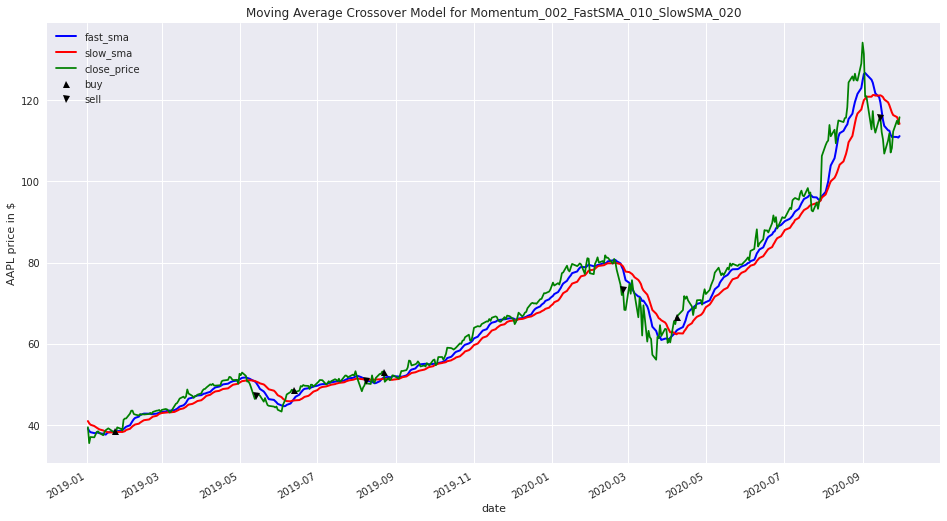

In [24]:
# Display the details for the top model
return_list = [momentum_fast_sma_slow_sma_performance.iloc[0]['return_value'], reversion_fast_sma_slow_sma_performance.iloc[0]['return_value']]
performance_list = [momentum_fast_sma_slow_sma_performance, reversion_fast_sma_slow_sma_performance]
portfolio_list = [momentum_fast_sma_slow_sma_portfolios, reversion_fast_sma_slow_sma_portfolios]
model_list = [momentum_fast_sma_slow_sma_models, reversion_fast_sma_slow_sma_models]
fast_ma_list = ['fast_sma', 'fast_sma']
slow_ma_list = ['slow_sma', 'slow_sma']
top_model_return = max(return_list)
top_model_index = return_list.index(top_model_return)
top_model_name = performance_list[top_model_index].iloc[0]['model_name']
display_signals_transactions(top_model_name, portfolio_list[top_model_index], model_list[top_model_index])
print()
draw_model_graphs(top_model_name, model_list[top_model_index][top_model_name], fast_ma_list[top_model_index], slow_ma_list[top_model_index])

In [25]:
print('The best model found is:', top_model_name)
print('The best profit/loss for the investing period is: $%.2f' % top_model_return)
if initial_capital != 0:
    print('The best return percentage for initial capital is: %.2f%%' % (top_model_return / initial_capital * 100))

The best model found is: Momentum_002_FastSMA_010_SlowSMA_020
The best profit/loss for the investing period is: $80.42


In [26]:
# Calculate the stock's performance for a buy-and-hold model
model_template = model_template[model_start_date:model_end_date]
print('The entry point for the buy-and-hold model: $%.2f on %s' % (model_template.iloc[0]['open_price'], model_template.index[0]))
print('The exit point for the buy-and-hold model: $%.2f on %s' % (model_template.iloc[-1]['close_price'], model_template.index[-1]))
print('The performance of the long-only model from day one is: $%.2f' %(model_template.iloc[-1]['close_price'] - model_template.iloc[0]['open_price']))

The entry point for the buy-and-hold model: $38.72 on 2019-01-02 00:00:00
The exit point for the buy-and-hold model: $115.81 on 2020-09-30 00:00:00
The performance of the long-only model from day one is: $77.09


In [27]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:03:25.059836
